In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import copy
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 378 (delta 78), reused 64 (delta 62), pack-reused 258
Receiving objects: 100% (378/378), 26.97 MiB | 42.81 MiB/s, done.
Resolving deltas: 100% (198/198), done.


In [ ]:
from continualai.colab.scripts import mnist

mnist.init()

Download complete.
Save complete.


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [ ]:
class my_model(
    nn.Module
    ): 

    def __init__(
        self
        ):

        super(my_model, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.drop_1 = nn.Dropout2d()
        self.fc_1 = nn.Linear(320, 50)
        self.drop_2 = nn.Dropout1d()
        self.fc_2 = nn.Linear(50, 10)

    def forward(
        self, 
        x
        ):
      
        x = F.relu(F.max_pool2d(self.conv_1(x), 2))
        x = F.relu(F.max_pool2d(self.drop_1(self.conv_2(x)), 2))
        x = x.view(-1, 320)
        x = self.drop_2(F.relu(self.fc_1(x)))
        x = self.fc_2(x)
        
        return x

In [ ]:
class my_agent():

  def __init__(
      self,
      ewc_flag=False
      ):
    
    X_train, self.Y_train, X_test, self.Y_test = mnist.load()
    self.X_train, self.X_test = [X_train], [X_test]

    self.batch_size = 256

    self.model = my_model()

    if torch.cuda.is_available():

      torch.cuda.manual_seed(1)
      self.device = torch.device('cuda')
      torch.cuda.set_device(0)

    else:

      self.device = torch.device('cpu')
      torch.manual_seed(1)

    self.model.to(self.device)

    learning_rate = 0.01
    momentum = 0.9
    self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate, momentum=momentum)
    self.ewc_flag, self.ewc_lambda, self.fisher, self.optpar = ewc_flag, 0.5, {}, {}

    self.criterion = nn.BCELoss()

  def add_permutation(
      self,
      seed
      ):

    np.random.seed(seed)
    permute_idx = list(range(784))
    np.random.shuffle(permute_idx)

    self.X_train.append(self.X_train[0].reshape(self.X_train[0].shape[0], 784)[:, permute_idx].reshape(self.X_train[0].shape[0], 1, 28, 28))
    self.X_test.append(self.X_test[0].reshape(self.X_test[0].shape[0], 784)[:, permute_idx].reshape(self.X_test[0].shape[0], 1, 28, 28))

  def update_task(
      self,
      task_num,
      X_train,
      Y_train
      ):
    
    self.model.train()
    self.optimizer.zero_grad()

    for start in range(0, len(Y_train) - 1, self.batch_size):

      end = start + self.batch_size

      x, y = torch.from_numpy(X_train[start:end]), torch.from_numpy(Y_train[start:end]).long()
      x, y = x.to(self.device), y.to(self.device)

      outputs = self.model(x)

      loss = F.cross_entropy(outputs, y)
      loss.backward()

    self.fisher[task_num], self.optpar[task_num] = {}, {}

    for name, param in self.model.named_parameters():
    
      self.optpar[task_num][name] = param.data.clone()
      self.fisher[task_num][name] = param.grad.data.clone().pow(2)

    self.optimizer.zero_grad()

  def run(
      self
      ):
    
    self.add_permutation(0)
    self.add_permutation(1)
    self.add_permutation(2)
    
    self.train_losses = []
    self.test_losses = [[] for perm in range(len(self.X_train))]
    self.test_correct = [[] for perm in range(len(self.X_train))]

    for perm in range(len(self.X_train)):

      for epoch in range(3):

        train_loss = self.train_epoch(self.X_train[perm], self.Y_train, perm)
        self.train_losses.append(train_loss)

        for p in range(len(self.X_train)):
          
          test_loss, test_correct = self.test_epoch(self.X_test[p], self.Y_test)
          self.test_losses[p].append(test_loss)
          self.test_correct[p].append(test_correct)

        self.update_task(perm, self.X_train[perm], self.Y_train)
        
    print("C'est fini!")

  def train_epoch(
      self,
      X_train,
      Y_train,
      task_num
      ):
    
    self.model.train()

    train_loss = 0.0
    
    for start in range(0, len(Y_train) - 1, self.batch_size):

      end = start + self.batch_size

      x, y = torch.from_numpy(X_train[start:end]), torch.from_numpy(Y_train[start:end]).long()
      x, y = x.to(self.device), y.to(self.device)

      outputs = self.model(x)

      loss = F.cross_entropy(outputs, y)

      if self.ewc_flag:

        for task in range(task_num):

          for name, param in self.model.named_parameters():
            
            fisher = self.fisher[task][name]
            optpar = self.optpar[task][name]
            loss += (fisher * (optpar - param).pow(2)).sum() * self.ewc_lambda

      loss.backward()

      self.optimizer.step()
      self.optimizer.zero_grad()

      train_loss += loss.item()

    return train_loss / len(Y_train)

  def test_epoch(
      self,
      X_test,
      Y_test
      ):
    
    self.model.eval()

    test_loss = 0.0
    correct = 0

    with torch.no_grad():

      for start in range(0, len(Y_test) - 1, self.batch_size):

        end = start + self.batch_size

        x, y = torch.from_numpy(X_test[start:end]), torch.from_numpy(Y_test[start:end]).long()
        x, y = x.to(self.device), y.to(self.device)

        outputs = self.model(x)

        loss = F.cross_entropy(outputs, y)
        test_loss += loss.item()

        predicted = outputs.max(1, keepdim=True)[1]
        correct += predicted.eq(y.view_as(predicted)).sum().item()

      return test_loss / len(Y_test), correct / len(Y_test) * 100

In [ ]:
agent = my_agent()
agent.run()

agent_ewc = my_agent(ewc_flag=True)
agent_ewc.run()

C'est fini!
C'est fini!


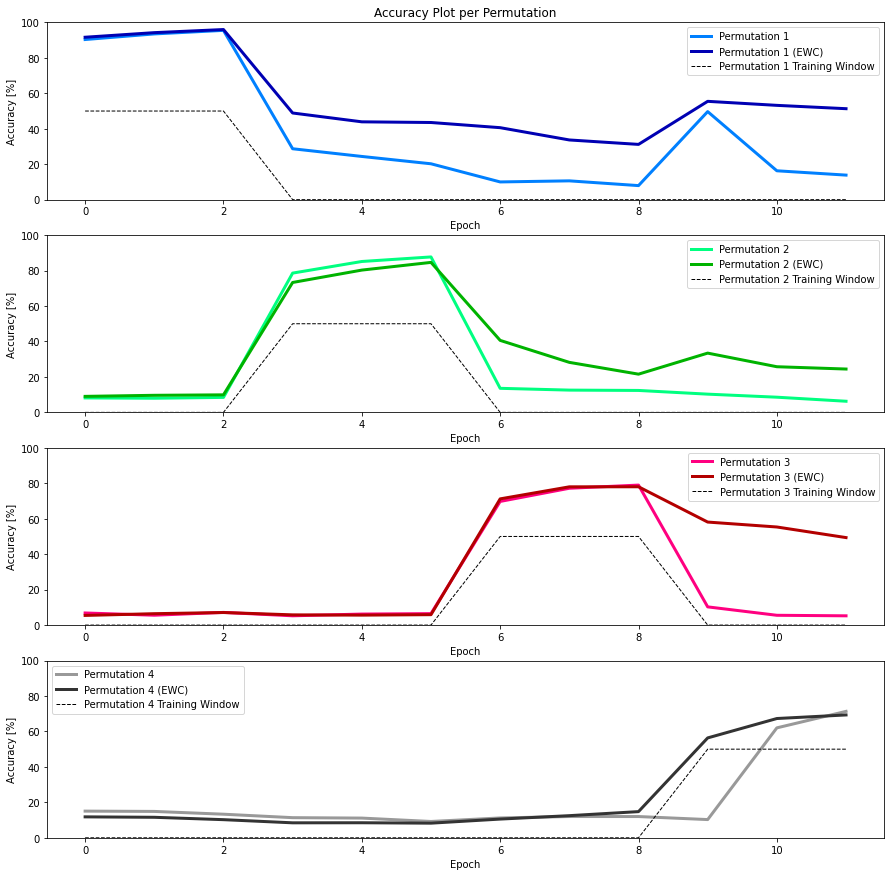

In [ ]:
results = np.array(agent.test_correct)
results_ewc = np.array(agent_ewc.test_correct)

task_window_1 = [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
task_window_2 = [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
task_window_3 = [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0]
task_window_4 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

plt.figure(figsize=(15,15))
plt.subplot(411)
plt.title("Accuracy Plot per Permutation")
plt.plot(results[0, :], linewidth=3, color=[0,0.5,1], label="Permutation 1")
plt.plot(results_ewc[0, :], linewidth=3, color=[0,0,0.7], label="Permutation 1 (EWC)")
plt.plot(50 * np.array(task_window_1), linestyle="--", linewidth=1, color=[0,0,0], label="Permutation 1 Training Window")
plt.ylim([0, 100])
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.subplot(412)
plt.plot(results[1, :], linewidth=3, color=[0,1,0.5], label="Permutation 2")
plt.plot(results_ewc[1, :], linewidth=3, color=[0,0.7,0], label="Permutation 2 (EWC)")
plt.plot(50 * np.array(task_window_2), linestyle="--", linewidth=1, color=[0,0,0], label="Permutation 2 Training Window")
plt.ylim([0, 100])
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.subplot(413)
plt.plot(results[2, :], linewidth=3, color=[1,0,0.5], label="Permutation 3")
plt.plot(results_ewc[2, :], linewidth=3, color=[0.7,0,0], label="Permutation 3 (EWC)")
plt.plot(50 * np.array(task_window_3), linestyle="--", linewidth=1, color=[0,0,0], label="Permutation 3 Training Window")
plt.ylim([0, 100])
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.subplot(414)
plt.plot(results[3, :], linewidth=3, color=[0.6,0.6,0.6], label="Permutation 4")
plt.plot(results_ewc[3, :], linewidth=3, color=[0.2,0.2,0.2], label="Permutation 4 (EWC)")
plt.plot(50 * np.array(task_window_4), linestyle="--", linewidth=1, color=[0,0,0], label="Permutation 4 Training Window")
plt.ylim([0, 100])
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")
plt.show()